In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'

from keras import backend as K
from keras.optimizers import Adam

from med_FCN import FCN, FCN_2, FCN_AlexNet
from med_data import generate_arrays_from_file, load_data, distance_mark, load_data_auto_seg
from med_DeconvNetModel import DeconvNet
from med_preprocess import Preprocess 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import maxflow

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN not available)


In [200]:
total_class = 2
ins = Preprocess("D:/Work/data/SrrData/",number_classes=total_class)
def train_load(path,model_name="FCN"):
    print "train_load"

    nb_epoch = 10
    batch_size = 10
    learning_rate = 1e-6
    decay_rate = 5e-5
    momentum_rate = 0.9
    sample_per_ep = 12133
  
    from keras.optimizers import SGD
    sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=momentum_rate, nesterov=True)

    
    smooth =1.


    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        #y_pred_f = K.update(y_pred_f[(y_pred_f >=0.5).nonzero()],1.)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    model_dec = { "FCN" : FCN_2, "DeconvNet" : DeconvNet, "FCN_alex" : FCN_AlexNet}
    model =model_dec[model_name](total_class)
    
    model.load_weights("weights_of_FCN_alex_ADAM_mask_SrrData_20_cross1.hdf5")
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=learning_rate),#'adadelta',
                  metrics=[dice_coef])



    #trains_list,trainl_list = load_data_auto_seg()
    
    
       
    #from keras.callbacks import ModelCheckpoint
    #checkpointer = ModelCheckpoint(filepath="weights_of_FCN_alex_ADAM_mask_po6_19.hdf5", verbose=1, save_best_only=True)
    #print trains_list.shape
    
    history = model.fit_generator(ins.generate_arrays_from_file(),samples_per_epoch=sample_per_ep,nb_epoch=nb_epoch 
                                 #,callback=[checkpointer]
                                  ,verbose=2
                                  ,validation_data=ins.generate_arrays_from_file(is_train=False),nb_val_samples=3033)
    #history = model.fit(trains_list, trainl_list, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.3, callbacks=[checkpointer])
    model.save_weights("weights_of_FCN_alex_ADAM_mask_SrrData_30_cross1.hdf5")#,by_name=True)
    return model

def load_model(weight_path,model_name="FCN"):
    model_dec = { "FCN" : FCN_2, "DeconvNet" : DeconvNet, "FCN_alex" : FCN_AlexNet}
    model = model_dec[model_name](total_class)
    
    smooth =1.

    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        #y_pred_f = K.update(y_pred_f[(y_pred_f >=0.5).nonzero()],1.)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    
    model.load_weights(weight_path)
    model.compile(loss=dice_coef_loss,#"categorical_crossentropy",
                  optimizer=Adam(lr=5e-5),#'adadelta',
                  metrics=[dice_coef])
    return model

def predict_data(dataPath, model):
    #output shape (sample, total_pixel, number of classes)
    data_file = ins.load_file(dataPath)
    output = model.predict_on_batch([data_file])
    return output
    

In [201]:
model = train_load('./med_train.txt',model_name="FCN_alex")#"DeconvNet")


train_load
(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 2, 14, 14)
(None, 2, 28, 28)
(None, 50176, 2)
Epoch 1/10
1158s - loss: 0.0199 - dice_coef: 1.0194 - val_loss: 0.0215 - val_dice_coef: 1.0188
Epoch 2/10
1128s - loss: 0.0194 - dice_coef: 1.0197 - val_loss: 0.0210 - val_dice_coef: 1.0191
Epoch 3/10
1122s - loss: 0.0198 - dice_coef: 1.0194 - val_loss: 0.0214 - val_dice_coef: 1.0188
Epoch 4/10
2777s - loss: 0.0193 - dice_coef: 1.0197 - val_loss: 0.0210 - val_dice_coef: 1.0192
Epoch 5/10
1612s - loss: 0.0197 - dice_coef: 1.0195 - val_loss: 0.0213 - val_dice_coef: 1.0190
Epoch 6/10
1466s - loss: 0.0192 - dice_coef: 1.0199 - val_loss: 0.0208 - val_dice_coef: 1.0191
Epoch 7/10
1182s - loss: 0.0196 - dice_coef: 1.0195 - val_loss: 0.0211 - val_dice_coef: 1.0191
Epoch 8/10
1158s - loss: 0.0191 - dice_coef: 1.0200 - val_loss: 0.0207 - val_dice_coef: 1.0190
Epoch 9/10
1169s - loss: 0.0194 - dice_coef: 1.0195 - val_loss: 0.0212 - val_dice_coef: 1.0192
Epoch 10/10
1166s - loss: 0.0190 - dice_c

In [202]:
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def deepCut(input_data, unary_data, test_index=0, sigma = 0.2, bcon= 0.4,debug = False):
    
    sigma = sigma
    # Create the graph.
    g = maxflow.Graph[float](0.0, 0.0)
    bcon = bcon
    # Add the nodes.
    nodeids = g.add_grid_nodes(input_data.shape)

    # Add edges with the same capacities.
    ###
    eLR = input_data[...,0:input_data.shape[1]-1]-input_data[...,1:input_data.shape[1]]
    eUD = input_data[0:input_data.shape[0]-1,...]-input_data[1:input_data.shape[0],...]
    for index_eLR in range (1,input_data.shape[1]-1): #removeborder
        for index_eUD in range (1,input_data.shape[0]-1): #remobeborder
            edge1 = np.exp(-abs(eLR[index_eUD,index_eLR-1])/(2*sigma*sigma))
            edge2 = np.exp(-abs(eLR[index_eUD,index_eLR])/(2*sigma*sigma))
            edge3 = np.exp(-abs(eUD[index_eUD-1,index_eLR])/(2*sigma*sigma))
            edge4 = np.exp(-abs(eUD[index_eUD,index_eLR])/(2*sigma*sigma))
            #input_data[index_eUD,index_eLR] = edge1+ edge2 + edge3 + edge4
            g.add_edge(nodeids[index_eUD][index_eLR], nodeids[index_eUD][index_eLR-1], edge1, edge1)#link back
            g.add_edge(nodeids[index_eUD][index_eLR], nodeids[index_eUD-1][index_eLR], edge3, edge3)#link back
            #g.add_edge(nodes[0], nodes[1], 1, 2)
    ###
    #g.add_grid_edges(nodeids, img_data)
    # Add the terminal edges.
    img_prob = np.zeros_like(input_data)
    img_prob = unary_data[0][:,test_index:test_index+1].reshape((input_data.shape[0],input_data.shape[1]))
    g.add_grid_tedges(nodeids, (img_prob)*(1-bcon), (1.0-(img_prob))*(1-bcon))
    g.maxflow()

    # Get the segments.
    sgm = g.get_grid_segments(nodeids)

    # The labels should be 1 where sgm is False and 0 otherwise.
    img2 = np.int_(np.logical_not(sgm))
    # Show the result.
    softmax_res = result_softmax[0][:,test_index:test_index+1].reshape((input_data.shape[0],input_data.shape[1]))
    softmax_argmax = result_softmax[0].argmax(axis=1).reshape((input_data.shape[0],input_data.shape[1]))
    if debug:
        imshow(input_data,img2, softmax_argmax)
    return img2, softmax_argmax

def comparison(result, target,debug = False):
    img_compare = np.zeros_like(target)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for x in range (target.shape[0]):
        for y in range (target.shape[1]):
            if target[x][y]!= 0:
                if result[x][y] !=0:
                    img_compare[x][y] = 1
                    TP += 1
                else:
                    img_compare[x][y] = 0.66
                    FN +=1
            else:
                if result[x][y] !=0:
                    img_compare[x][y] = 0.33
                    TN +=1
                else:
                    img_compare[x][y] = 0
                    FP +=1
    upper = (2.0*(TP))
    lower = (2.0*TP+TN+FN)
    if (lower ==0):
        dice = 1
    else:
        dice = upper/lower
    if debug:
        print ('--------------------------------')
        print ('Ture positive: '), TP
        print ('Ture Negative: '), TN
        print ('False positive: '), FP
        print ('False Negative: '), FN
        print ('Dice Coefficient: '), (2.0*(TP))/(2.0*TP+TN+FN) 
    
    return img_compare, dice

(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 2, 14, 14)
(None, 2, 28, 28)
(None, 50176, 2)


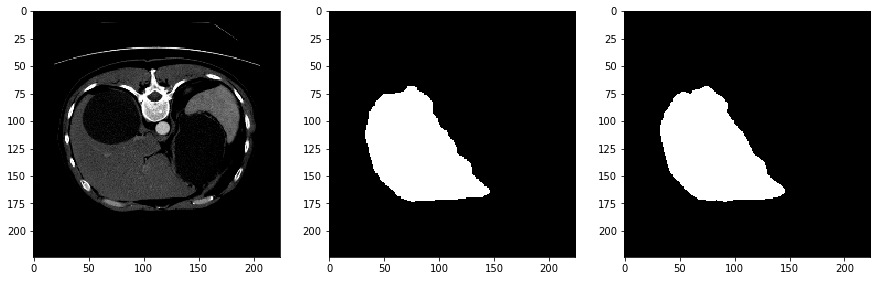

In [206]:
file_name = 'Srr128_ART.mhd_2_30.png'
dir_path = r'D:\Work\data\SrrData'
path_train = dir_path+'\\train_224\\'
path_target = dir_path+'\\target_224\\'


model = load_model("weights_of_FCN_alex_ADAM_mask_SrrData_30_cross1.hdf5",model_name="FCN_alex")
result_softmax = predict_data(path_train+file_name,model)
output_max = np.argmax(result_softmax[0],axis=1).reshape((224,224))
class_map = result_softmax[:,:,0].reshape((224,224))

data_file = ins.load_file(path_train+file_name)#D:\Work\data\SrrData\train_224\s&p_Srr114_ART.mhd_2_23.png')
final_result, softmax_argmax = deepCut(data_file[0][0], result_softmax, test_index=1,bcon=0.4,sigma=0.2 , debug = True)



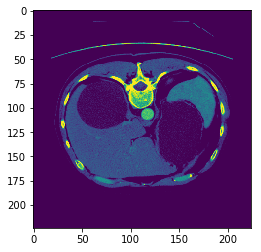

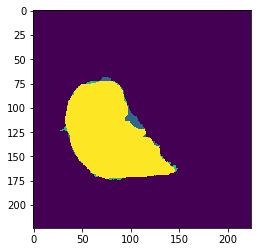

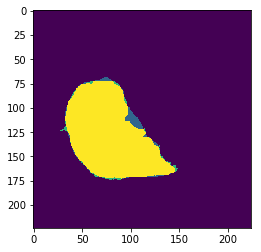

0.967230223335


In [207]:
label_file = ins.load_file(path_target+file_name)
plt.imshow(data_file[0][0])
plt.show()
final_result,dice = comparison(final_result, label_file[0][0])


plt.imshow(final_result)
plt.show()

final_arg_result,dice = comparison(softmax_argmax, label_file[0][0])

plt.imshow(final_arg_result)
plt.show()
print dice




In [196]:
data_file[0][0].shape[0]

224L

In [198]:
model = load_model("weights_of_FCN_alex_ADAM_mask_SrrData_20_cross1.hdf5",model_name="FCN_alex")




f = open(dir_path+'\\training_sheets\\2_p\\val.txt')
data1 = f.read()
f.close()
lines1 = data1.split('\n')

avg_dice_our = 0
avg_dice_FCN = 0
file_count = 0
for line in lines1:
    file_count = file_count+1
    print ('-----------'),line,('-----------')
    result_softmax = predict_data(path_train+line,model)
    data_file = ins.load_file(path_train+line)#D:\Work\data\SrrData\train_224\s&p_Srr114_ART.mhd_2_23.png')
    label_file = ins.load_file(path_target+line)
    
    final_result, softmax_argmax = deepCut(data_file[0][0], result_softmax, test_index=1,bcon=0.4,sigma=0.2 )
    final_result,dice = comparison(final_result, label_file[0][0])
    avg_dice_our = avg_dice_our+ dice
    print "our dice: ", dice
    final_arg_result,dice = comparison(softmax_argmax, label_file[0][0])
    avg_dice_FCN = avg_dice_FCN+ dice
    print "FCN dice: ", dice
    


(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 2, 14, 14)
(None, 2, 28, 28)
(None, 50176, 2)
----------- Srr202_NC.mhd_2_14.png -----------
our dice:  0.978636951302
FCN dice:  0.978841527358
----------- s&p_Srr416_ART.mhd_2_13.png -----------
our dice:  0.878419452888
FCN dice:  0.877621044605
----------- Srr138_ART.mhd_2_27.png -----------
our dice:  0.957705038617
FCN dice:  0.954209748892
----------- speckle_Srr410_PV.mhd_2_21.png -----------
our dice:  0.972220555589
FCN dice:  0.969758913004
----------- Srr326_ART.mhd_2_34.png -----------
our dice:  0.931549960661
FCN dice:  0.939759036145
----------- speckle_Srr406_ART.mhd_2_43.png -----------
our dice:  0.924855491329
FCN dice:  0.914893617021
----------- speckle_Srr104_NC.mhd_2_68.png -----------
our dice:  0.959299781182
FCN dice:  0.955552379591
----------- s&p_Srr219_PV.mhd_2_12.png -----------
our dice:  0.974153705398
FCN dice:  0.968215720023
----------- speckle_Srr317_ART.mhd_2_8.png -----------
our dice:  0.53947368421

error: ..\..\..\modules\imgproc\src\color.cpp:3739: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [199]:
print "file count: ", file_count
print "AVG our dice: ", (float)(avg_dice_our)/(float)(file_count)
print "AVG FCN dice: ", (float)(avg_dice_FCN)/(float)(file_count)

file count:  6204
AVG our dice:  0.910802934472
AVG FCN dice:  0.905310068889


In [183]:
avg_dice_FCN

289.0316419022946